In [1]:
import os
import torch
import numpy as np
import torchvision
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms as T,datasets
import random 
import timm
import torch.nn.functional as F
import sys
print('Python VERSION: \t', sys.version)
print('pyTorch VERSION:\t', torch.__version__)
print('pyTorch VERSION:\t', torchvision.__version__)
print('CUDA VERSION: \t', )
print('CUDNN VERSION:\t\t', torch.backends.cudnn.version())

print('Cuda is availabel:\t', torch.cuda.is_available())
print('Cuda device number:\t', torch.cuda.current_device())
print('Cuda count:\t\t', torch.cuda.device_count())
print('Cuda device name:\t', torch.cuda.get_device_name(0))
print('Torch Cuda Version: \t', torch.version.cuda)

Python VERSION: 	 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
pyTorch VERSION:	 1.7.1
pyTorch VERSION:	 0.8.2
CUDA VERSION: 	
CUDNN VERSION:		 7605
Cuda is availabel:	 True
Cuda device number:	 0
Cuda count:		 1
Cuda device name:	 GeForce RTX 2080 Ti
Torch Cuda Version: 	 10.2


In [2]:
def show_image(image, label, get_denormalize = True):
    '''
    Helper Gunction for showing the image
    '''
    image = image.permute(1,2,0)
    mean, std = torch.FloatTensor([0.485, 0.456, 0.406]), torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize==True:
        image = image * std + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(label)
    else:
        plt.imshow(image)
        plt.title(label)

In [4]:
def show_grid(image, title = None):
    '''
    Helper Function for showing the image in the grid
    '''
    image = image.permute(1,2,0)
    mean, std = torch.FloatTensor([0.485, 0.456, 0.406]), torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.figure(figsize = [15,15])
    plt.imshow(image)
    if title != None:
        plt.title(title)
        

In [5]:
def accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [6]:
def view_classify(image, ps, label):
    class_name = ['No-Flooded Image', 'Flooded Image']
    classes = np.array(class_name)
    ps = ps.cpu().data.numpy().squeeze()
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    img = np.clip(image,0,1)
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

    return None

In [7]:
## Configuration
class CFG:
    epochs =20 # nomber epoch to train model
    lr = 0.001 # learning rate (How NN updates the gradient)
    batch_size = 16 # 16 images in one batchs
    model_name = 'tf_efficientnet_b4_ns' #(The model imported from timm)
    img_crop = 224 # Crop all images to be 224x224 after resizing
    img_size = 256 # Resize all images to be 256x256
    
    train_path = '/home/igofed/LiU/AI4Climate_/weather_2_0/train'
    validate_path = '/home/igofed/LiU/AI4Climate_/weather_2_0/valid'
    test_path = '/home/igofed/LiU/AI4Climate_/weather_2_0/test'
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


In [8]:
# Train Dataset 
# Set of data used for learning (by the model), that is, to fit the parameters to the machine learning model
train_transform = T.Compose([
                                T.Resize(size=(CFG.img_size, CFG.img_size)), #Resizing the image to be 224 x 224
                                #T.CenterCrop(size=(CFG.img_crop, CFG.img_crop)), #Resizing the image to be 224 x 224
                                T.RandomRotation(degrees=(-20,20)), #Randomly Rotate Images by +/- 20 degree, Image argumentation for each epoch
                                T.ToTensor(), # converting the dimention from (height, wight, channel) to (channel, height, weight) convention of pytorch
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize by 3 means 2 STDs of the image net, 3 channel
])

validate_transform = T.Compose([
                                T.Resize(size=(CFG.img_size, CFG.img_size)), #Resizing the image to be 224 x 224
                                #T.RandomRotation(degrees=(-20,20)), #No need to validation
                                T.ToTensor(), # converting the dimention from (height, wight, channel) to (channel, height, weight) convention of pytorch
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.2258]) # Normalize by 3 means 2 STDs of the image net, 3 channel
])
test_transform = T.Compose([
                                T.Resize(size=(CFG.img_size, CFG.img_size)), #Resizing the image to be 224 x 224
                                #T.RandomRotation(degrees=(-20,20)), #No need to validation
                                T.ToTensor(), # converting the dimention from (height, wight, channel) to (channel, height, weight) convention of pytorch
                                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.2258]) # Normalize by 3 means 2 STDs of the image net, 3 channel
])

In [9]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Train set Size: \t\t{}".format(len(trainset)))
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("Validate set Size:  \t{}".format(len(validateset)))
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("Test set Size:  \t\t{}".format(len(testset)))

Train set Size: 		2314
Validate set Size:  	289
Test set Size:  		290


1


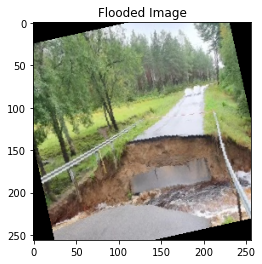

In [12]:
# Test how the data looks like
N = random.randint(0, len(trainset))
img, label = trainset[N]
print(label)
#print(trainset.class_to_idx)
class_name = ['No-Flooded Image', 'Flooded Image']
show_image (img, class_name[label])

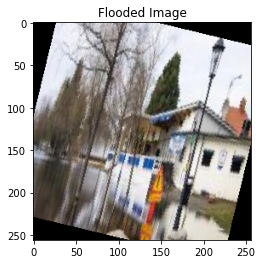

In [13]:
N = random.randint(0, len(trainset))
img, label = trainset[N]
class_name = ['No-Flooded Image', 'Flooded Image']
show_image (img, class_name[label])

In [23]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader: \t{}".format(len(trainloader))) #TrainsetSize: 5216 / batch_size:16 = 326 No of batches in trainloader
print("No. of total examples: \t\t{}".format(len(trainloader.dataset)))

No. of batches in trainloader: 	145
No. of total examples: 		2314


In [24]:
validationloader = DataLoader(validateset, batch_size = CFG.batch_size, shuffle=True)
print("No. of batches in validationloader: \t{}".format(len(validationloader))) 
print("No. of total examples: \t\t\t{}".format(len(validationloader.dataset)))

No. of batches in validationloader: 	19
No. of total examples: 			289


In [25]:
testloader = DataLoader(testset, batch_size = CFG.batch_size, shuffle=True)
print("No. of batches in testloader: \t{}".format(len(testloader))) #TestSet: 624 / batch_size:16 = 39 No of batches in testloader
print("No. of total examples: \t\t{}".format(len(testloader.dataset)))

No. of batches in testloader: 	19
No. of total examples: 		290


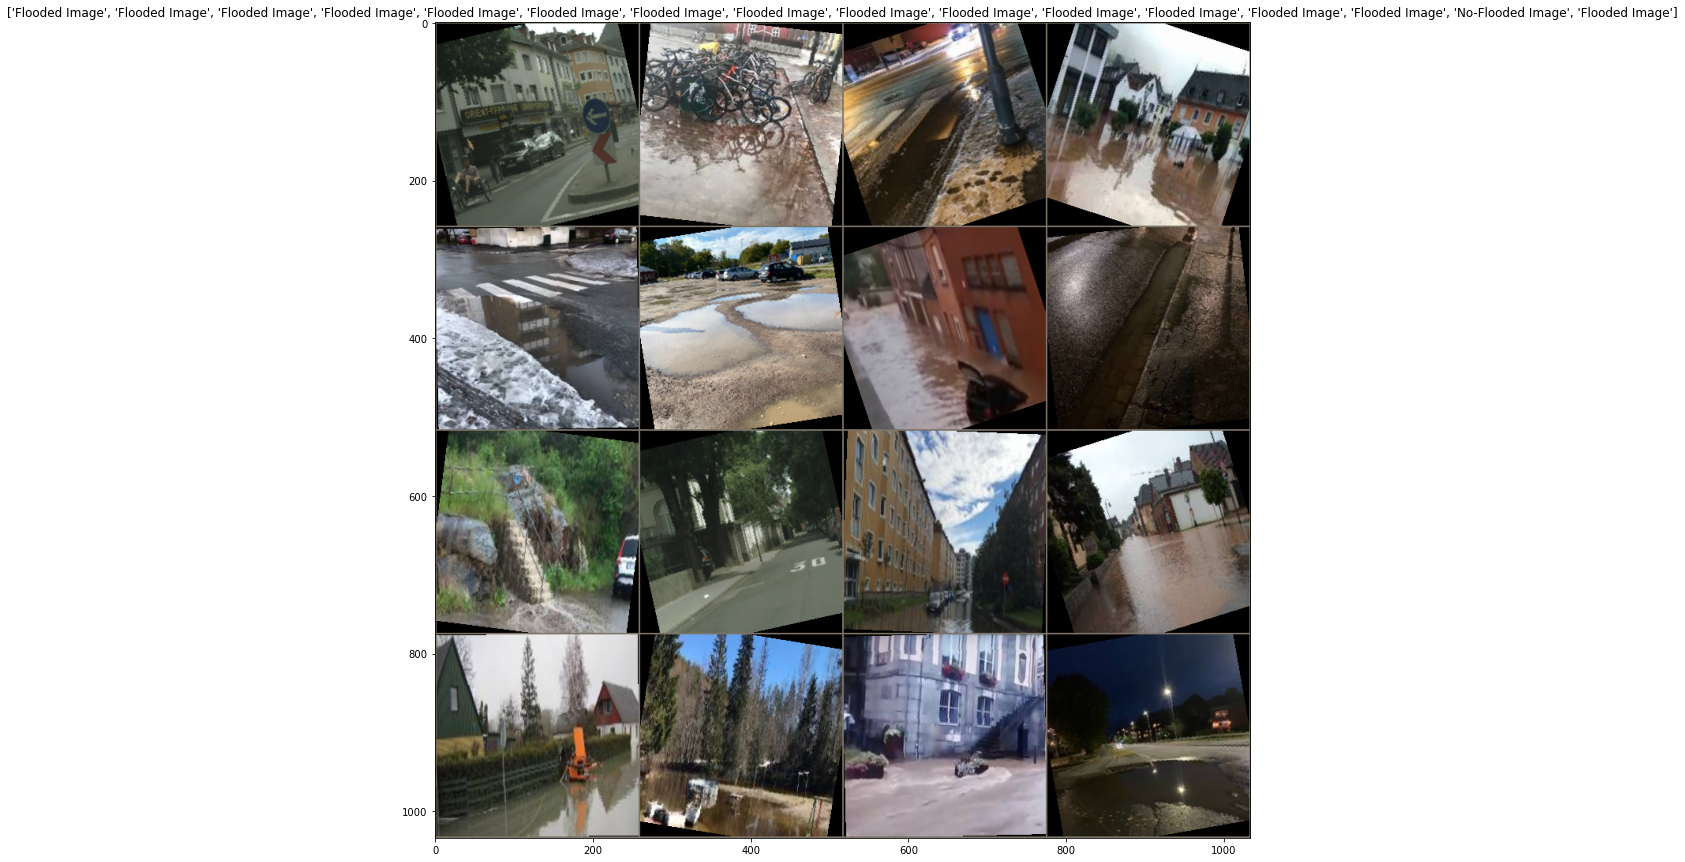

In [26]:
#Showing some of the images in the training dataset after the loading data
detaiter = iter(trainloader)
images, labels = detaiter.next()
out = make_grid(images, nrow =4)
show_grid(out, title = [class_name[x] for x in labels ])

In [27]:
#model
# update pretrained model
model = timm.create_model(CFG.model_name, pretrained=True) #load pretrained model
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [28]:
for param in model.parameters():
    param.requires_grad = False
# update classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    torch.nn.ReLU(), #ReLu to be the activation function
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features=625, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=2), 
)

model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [17]:
for param in model.parameters():
    param.requires_grad = False
# update classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    torch.nn.ReLU(), #ReLu to be the activation function
    torch.nn.Dropout(p=0.3),
    torch.nn.Linear(in_features=625, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=2), 
)

model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [29]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
          Identity-2         [-1, 48, 112, 112]               0
              SiLU-3         [-1, 48, 112, 112]               0
    BatchNormAct2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             432
          Identity-6         [-1, 48, 112, 112]               0
              SiLU-7         [-1, 48, 112, 112]               0
    BatchNormAct2d-8         [-1, 48, 112, 112]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13         [-1, 48, 112, 112]               0
           Conv2d-14         [-1, 24, 1

In [21]:
class FloodNonFloodTrainer():
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        self.train_loss = []
        self.train_acc = []
        self.valid_loss = []
        self.valid_acc = []
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'model.pt')
                valid_min_loss = avg_valid_loss
            
            
            self.train_loss.append(avg_train_loss)
            self.train_acc.append(avg_train_acc)
            self.valid_loss.append(avg_valid_loss)
            self.valid_acc.append(avg_valid_acc)

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = FloodNonFloodTrainer(criterion,optimizer)
trainer.fit(model,trainloader, validationloader,epochs = CFG.epochs)

NameError: name 'validationloader' is not defined

In [20]:
model.load_state_dict(torch.load('weather_1_0.pt'))
model.eval()
avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model, testloader)
print("Test Loss: {}".format(avg_test_loss))
print("Test Acc: {}".format(avg_test_acc))


  0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 0.21691741957329214
Test Acc: 0.9117187261581421


In [7]:
# Test how the data looks like
count = 0
while (count >2):
    N = random.randint(0, len(testset))
    image, label = testset[N]
    #if label ==1:
    count = count +1
    print(label)
        
    #print(N)
    #image, label = testset[N]
    #print(label)
    #i=i+1
#print(trainset.class_to_idx)
#ps = F.softmax(ps, dim = 1)
#view_classify(image, ps, label )
# Python program to illustrate
# while loop
count = 0
import random
while (count < 3):
    N = random.randint(0, len(testset))
    image, label = testset[N]
    count = count + 1

    print("Hello Geek")


NameError: name 'testset' is not defined